In [1]:
import dgl

import torch
import torch.nn as nn

import networkx as nx

from gsp_utils.data import get_data_dgl, pert_S

from arch.model import RobustGNNModel1

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Single dataset test

In [3]:
dataset = "WisconsinDataset"
S, feat, labels, n_class, masks = get_data_dgl(dataset, dev=device)

In [4]:
n_iters_H = 10
n_epochs = 25
lr = 0.01
wd = 5e-4
eval_freq = 1

lr_S = 5e-3

n_iters = 10
n_iters_S = 1#15

hid_dim = 16
n_layers = 2

in_dim = feat.shape[1]
out_dim = n_class

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'act': nn.ReLU(),
    'bias': True,
    'last_act': nn.LogSoftmax(dim=1),
    'dropout': 0.5,
    'K': 3
}

gamma = 0
beta = 0.01
lambd = 1.

In [5]:
eps = 0.15
Sn = torch.Tensor(pert_S(S, eps=eps)).to(device)

S = torch.Tensor(S).to(device)

torch.linalg.norm(Sn/torch.linalg.norm(Sn) - S / torch.linalg.norm(S))

268
40.199999999999996


tensor(0.9580)

In [6]:
S_init = torch.zeros(Sn.shape, device=device)
model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m1, S_dict_m1 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, verbose=True)

Iteration 1 DONE - Acc Test: 0.7647058823529411 - Err S: 0.9972131252288818
Iteration 2 DONE - Acc Test: 0.7843137254901961 - Err S: 0.8875409960746765
Iteration 3 DONE - Acc Test: 0.7647058823529411 - Err S: 0.8938648104667664
Iteration 4 DONE - Acc Test: 0.7647058823529411 - Err S: 0.8987561464309692
Iteration 5 DONE - Acc Test: 0.7450980392156863 - Err S: 0.9026778936386108
Iteration 6 DONE - Acc Test: 0.7450980392156863 - Err S: 0.9058548212051392
Iteration 7 DONE - Acc Test: 0.7647058823529411 - Err S: 0.9084336757659912
Iteration 8 DONE - Acc Test: 0.7254901960784313 - Err S: 0.9105464816093445
Iteration 9 DONE - Acc Test: 0.803921568627451 - Err S: 0.9123011231422424
Iteration 10 DONE - Acc Test: 0.7450980392156863 - Err S: 0.9137746095657349


# Exhaustive Tests

In [7]:
EXPS = [
    {
        "dataset": "Cornell",
        "layer": "GCNH",
        "legend": "Cornell-GCNH",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNH",
        "legend": "Texas-GCNH",
        "fmt": "v--"
    },
    {
        "dataset": "Cornell",
        "layer": "RGFGCN",
        "legend": "Cornell-Robust-GCNH",
        "fmt": "d-"
    },
    {
        "dataset": "Texas",
        "layer": "RGFGCN",
        "legend": "Texas-Robust-GCNH",
        "fmt": "d--"
    },
]

In [17]:
perts = [0., 0.05, 0.1, 0.15, 0.2, 0.25]

n_graphs = 10

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):

    for j, exp in enumerate(EXPS):

        print(f"Starting pert {p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        for n in range(n_graphs):

            if exp['dataset'] == "Cornell" or exp['dataset'] == "Texas" or exp['dataset'] == "Wisconsin": # TODO: Implement cross validation properly
                idx = np.random.randint(10)
                S, feat, labels, n_class, masks = get_data_dgl(dataset, dev=device, idx=idx)
                
            print(f"{n+1} ", end="")
            
            Sn = pert_S(S.copy(), type="prob_nonsym", eps=p)
            if p == 0.:
                assert np.all(Sn == S)

            S = torch.Tensor(S).to(device)
            Sn = torch.Tensor(Sn).to(device)

            model = RobustGNNModel1(Sn, n_iters_H, lr, wd, lr_S, eval_freq, model_params,
                                    n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
            model.model = model.model.to(device)

            if exp['layer'] == "GCNH":
                model.n_iters_H = 50
                _, _, acc_test, _ = model.stepH(
                    feat, labels, masks['train'], masks['val'], masks['test'], verbose=False
                )
            elif exp['layer'] == "RGFGCN":
                results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                              train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                              norm_S=False, S_true=S, verbose=False
                                                             )
                acc_test = results_dict['accs_test'][-1,:]

            accs_test[n, j, i] = acc_test[-1]
        print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]:.5f}")

Starting pert 0.0 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.72353
Starting pert 0.0 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.73333
Starting pert 0.0 of exp Cornell - RGFGCN: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.74314
Starting pert 0.0 of exp Texas - RGFGCN: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.75882
Starting pert 0.05 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.76667
Starting pert 0.05 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.69608
Starting pert 0.05 of exp Cornell - RGFGCN: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.73137
Starting pert 0.05 of exp Texas - RGFGCN: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.76863
Starting pert 0.1 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.77451
Starting pert 0.1 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 DONE - Accuracy Test: 0.74510
Starting pert 0.1 of exp Cornell - RGFGCN: 1 2 3 4 5 6 7 8 9 10 DONE - Accurac

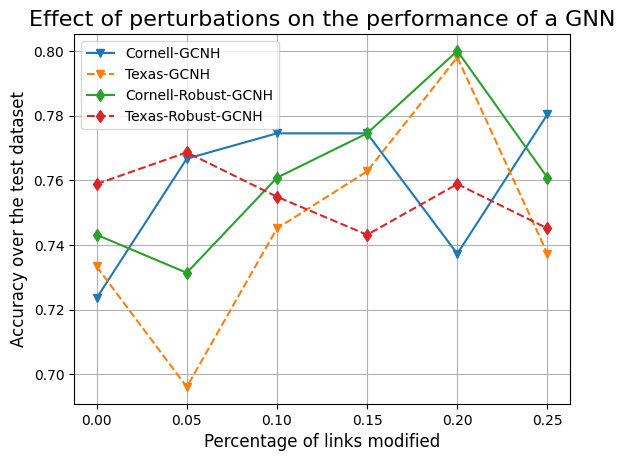

In [18]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()